# Multivariate time serie prediction for one feature

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from utils_plot import plot_series, plot_train_history, plot_prediction
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-beta1


In [3]:
CONFIG_PATH = '/root/work/artwork_sequence/train_test_configuration'
PLOT_PATH = '/root/work/artwork_sequence/plots'

In [4]:
museum_sequence_path = {
    'x_train' : os.path.join(CONFIG_PATH, 'X_train.csv'),
    'x_test' : os.path.join(CONFIG_PATH, 'X_test.csv'),
    'x_train_matrix' : os.path.join(CONFIG_PATH, 'X_train_matrix.npy'),
    'x_test_matrix' : os.path.join(CONFIG_PATH, 'X_test_matrix.npy')
}
museum_sequence_path

{'x_test': '/root/work/artwork_sequence/train_test_configuration/X_test.csv',
 'x_test_matrix': '/root/work/artwork_sequence/train_test_configuration/X_test_matrix.npy',
 'x_train': '/root/work/artwork_sequence/train_test_configuration/X_train.csv',
 'x_train_matrix': '/root/work/artwork_sequence/train_test_configuration/X_train_matrix.npy'}

## Load data

In [5]:
df_x_train = pd.read_csv(museum_sequence_path['x_train'], index_col=0)
df_x_test = pd.read_csv(museum_sequence_path['x_test'], index_col=0)
x_train_matrix = np.load(museum_sequence_path['x_train_matrix'])
x_test_matrix = np.load(museum_sequence_path['x_test_matrix'])
df_x_train.head()

,tour_path
20,/root/work/datasets/artwork_sequence/rijksmuse...
7,/root/work/datasets/artwork_sequence/rijksmuse...
40,/root/work/datasets/artwork_sequence/prado_cra...
0,/root/work/datasets/artwork_sequence/rijksmuse...
23,/root/work/datasets/artwork_sequence/prado_cra...


# Config data to fit with the model input


Because the **Prediction feature model** split the data into training and validation dataset, it is necessary to give all the data in only one block

**Define timeline**

In [6]:
time = np.arange(x_train_matrix.shape[0] + x_test_matrix.shape[0])
time.shape

(859,)

## Split dataset

**Define window size**

In [8]:
split_time = x_train_matrix.shape[0]

X = np.concatenate((x_train_matrix, x_test_matrix))
#Define feature to predict
feature_to_predict = 0
x_feature = X[:,feature_to_predict]

#Define influence features
n_features = X.shape[1]
indexes_features = np.random.choice(np.delete(np.arange(X.shape[1]), feature_to_predict), 3, replace=False)

x_inflence_features = X[:, list(indexes_features)]

#the length mean average of the tours
window_size = 4

batch_size = 128
shuffle_buffer_size = 300

In [9]:
#Stack feature to predict with influences features
x_feature = np.hstack(tup=(x_feature.reshape((-1,1)), x_inflence_features))

n_features = x_feature.shape[1]
n_features

4

**Create windowed dataset**

In [11]:
from Prediction_model_feature import Windowed_Dataset

In [12]:
dataset = Windowed_Dataset(x_feature,
                           split_time=split_time,
                           window_size=window_size, 
                           shuffle_buffer=shuffle_buffer_size,
                           train_batch_size=batch_size,
                            val_batch_size=batch_size)

In [13]:
train_set = dataset.get_train_dataset()
val_set = dataset.get_val_dataset()

**Plot example**

(4, 4)
0.0003882437


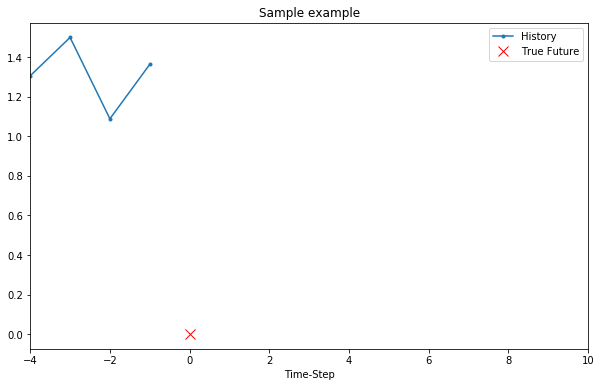

In [14]:
for x, y in train_set.take(1):
    print(x[0].numpy().shape)
    print(y[0].numpy())
    plot = plot_prediction([x[0][:, 0].numpy(), y[0].numpy()] , 'Sample example')
    #Necessary to save before you plot
    #plot.savefig(os.path.join(PLOT_PATH, 'sample_example.png'))
    plot.show()
    

## Define model

In [20]:
def define_model(ws, nf=1):

    tf.keras.backend.clear_session()
    tf.random.set_seed(51)
    np.random.seed(51)

    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[ws, nf]),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(32),
      tf.keras.layers.Dense(16, activation="relu"),
      tf.keras.layers.Dense(8, activation="relu"),
      tf.keras.layers.Dense(1, name="prediction"),
      tf.keras.layers.Lambda(lambda x: x * 400)
    ],
    name="Sequence_Feature_1")
    
    return model

In [24]:
model = define_model(window_size, n_features)
model.summary()

Model: "Sequence_Feature_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 32)             672       
_________________________________________________________________
lstm (LSTM)                  (None, 4, 64)             24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
prediction (Dense)           (None, 1)                 9         
_________________________________________________________________
lambda (Lambda)              (None, 1)          

**Train with different leraning rates**

In [25]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [26]:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 4s 816ms/step - loss: 4.8935 - mae: 5.3895
Epoch 2/100
5/5 [==============================] - 0s 40ms/step - loss: 4.8174 - mae: 5.3124
Epoch 3/100
5/5 [==============================] - 0s 38ms/step - loss: 4.6851 - mae: 5.1796
Epoch 4/100
5/5 [==============================] - 0s 35ms/step - loss: 4.5122 - mae: 5.0051
Epoch 5/100
5/5 [==============================] - 0s 40ms/step - loss: 4.3075 - mae: 4.7978
Epoch 6/100
5/5 [==============================] - 0s 37ms/step - loss: 4.0774 - mae: 4.5644
Epoch 7/100
5/5 [==============================] - 0s 39ms/step - loss: 3.8272 - mae: 4.3102
Epoch 8/100
5/5 [==============================] - 0s 33ms/step - loss: 3.5619 - mae: 4.0417
Epoch 9/100
5/5 [==============================] - 0s 38ms/step - loss: 3.2894 - mae: 3.7647
Epoch 10/100
5/5 [==============================] - 0s 37ms/step - l

5/5 [==============================] - 0s 35ms/step - loss: 17.6952 - mae: 18.0545
Epoch 85/100
5/5 [==============================] - 0s 36ms/step - loss: 20.8454 - mae: 21.5116
Epoch 86/100
5/5 [==============================] - 0s 34ms/step - loss: 33.1630 - mae: 33.6111
Epoch 87/100
5/5 [==============================] - 0s 34ms/step - loss: 25.3378 - mae: 25.6538
Epoch 88/100
5/5 [==============================] - 0s 39ms/step - loss: 29.7552 - mae: 30.4853
Epoch 89/100
5/5 [==============================] - 0s 33ms/step - loss: 47.0112 - mae: 47.4363
Epoch 90/100
5/5 [==============================] - 0s 33ms/step - loss: 36.2524 - mae: 36.4963
Epoch 91/100
5/5 [==============================] - 0s 35ms/step - loss: 42.2174 - mae: 43.0391
Epoch 92/100
5/5 [==============================] - 0s 38ms/step - loss: 66.4198 - mae: 66.8083
Epoch 93/100
5/5 [==============================] - 0s 38ms/step - loss: 51.0779 - mae: 51.2085
Epoch 94/100
5/5 [==============================] - 0

**Find best learning rate**

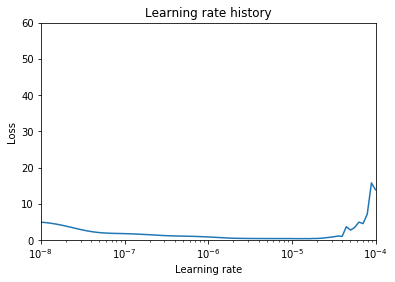

In [27]:
import matplotlib.pyplot as plt

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])
plt.title('Learning rate history')
plt.xlabel("Learning rate")
plt.ylabel("Loss")

plt.savefig(os.path.join(PLOT_PATH, 'learning_rate.png'))
plt.show()

**Train with the best learning rate**

In [30]:
model = define_model(window_size, n_features)

optimizer = tf.keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,
                    epochs=30,
                    validation_data=val_set)

Epoch 1/30
5/5 [==============================] - 6s 1s/step - loss: 3.4206 - mae: 3.9066 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/30
5/5 [==============================] - 0s 41ms/step - loss: 2.7180 - mae: 3.1975 - val_loss: 2.3664 - val_mae: 2.8098
Epoch 3/30
5/5 [==============================] - 0s 43ms/step - loss: 1.6358 - mae: 2.0961 - val_loss: 2.0104 - val_mae: 2.5114
Epoch 4/30
5/5 [==============================] - 0s 42ms/step - loss: 1.7318 - mae: 2.1879 - val_loss: 0.9183 - val_mae: 1.3047
Epoch 5/30
5/5 [==============================] - 0s 44ms/step - loss: 1.3726 - mae: 1.8249 - val_loss: 1.0778 - val_mae: 1.4959
Epoch 6/30
5/5 [==============================] - 0s 42ms/step - loss: 0.9865 - mae: 1.4068 - val_loss: 1.1474 - val_mae: 1.5822
Epoch 7/30
5/5 [==============================] - 0s 46ms/step - loss: 0.9147 - mae: 1.3242 - val_loss: 0.7542 - val_mae: 1.1825
Epoch 8/30
5/5 [==============================] - 0s 42ms/step - loss: 0.8061 - mae: 1.2326

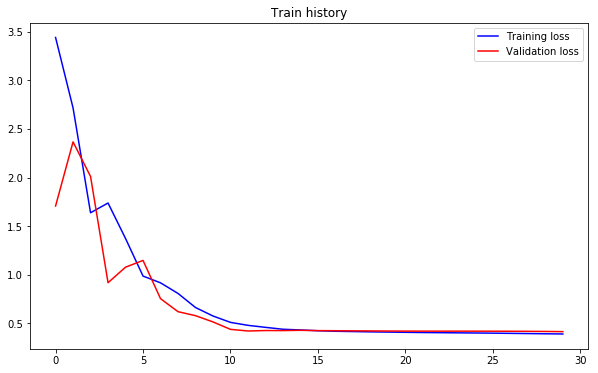

In [31]:
plot = plot_train_history(history, "Train history")
plot.savefig(os.path.join(PLOT_PATH, 'train_history.png'))
plot.show()

## Evaluate model

In [ ]:
for x, y in val_set.take(1):
    prediction = model.predict(x)[0]
    plot = plot_prediction([x[0][:, 0].numpy(), y[0].numpy(), prediction[0]] , 'Feature prediction model')
    plot.savefig(os.path.join(PLOT_PATH, 'prediction_single_point.png'))
    plot.show()

**Forecast all future**

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    #series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.map(lambda w: (w[:]))
    ds = ds.batch(batch_size)
    forecast = model.predict(ds)
    return forecast

In [ ]:
rnn_forecast = model_forecast(model, x_feature, window_size, batch_size)

In [ ]:
rnn_forecast = rnn_forecast[split_time-window_size+1:,-1]

In [ ]:
rnn_forecast.shape

**Plot serie**

In [ ]:
plot = plot_series(time[split_time:], [(rnn_forecast, 'rnn')])
plot.show()

In [ ]:
x_valid = x_feature[split_time:]
plot = plot_series(time[split_time:], [(x_valid[:,0], 'x_valid'), (rnn_forecast, 'rnn')])
plot.title('Forescast artwork sequence')
plot.savefig(os.path.join(PLOT_PATH, 'forescast_sequence.png'))

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid[:,0], rnn_forecast).numpy().mean()